# cDIA (difference image analysis on cropped exposures)

In [2]:
import astropy
import numpy as np
import pandas as pd
import sqlite3
import matplotlib as mpl
import scipy

In [3]:
from lsst.ip.diffim import subtractImages

# Import

In [4]:
import cDIA as cdia
import importlib as imp
imp.reload(cdia)

<module 'cDIA' from '/pscratch/sd/s/shl159/projects/update_plots/dia_improvement/devel/cDIA.py'>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import lsst
from lsst.daf.butler import Butler
from lsst.ip.diffim import GetTemplateConfig, GetTemplateTask
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog
import lsst.afw.display as afwDisplay
import lsst.geom as geom

In [6]:
def htm_from_ra_dec_level(ra, dec, level):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    return htm_id

def get_dataset_refs_from_htm_list(dataset_type, htm_ids, level, aggregate="intersection"):
    hi = htm_ids[0]

    # dataset_refs is an iterator, but each query is only a few hundred results,
    #   so convert to a list for future convenience
    htm_kwargs = {}
    htm_kwargs[f"htm{level}"] = hi
    dataset_refs = list(butler.registry.queryDatasets(dataset_type, dataId={"band": band}, **htm_kwargs))
    dataset_refs = set(dataset_refs)
    
    for hi in htm_ids[1:]:
        htm_kwargs = {}
        htm_kwargs[f"htm{level}"] = hi
        dr = list(butler.registry.queryDatasets(dataset_type, dataId={"band": band}, **htm_kwargs))
        if aggregate == "intersection":
            dataset_refs = dataset_refs.intersection(set(dr))
        elif aggregate == "union":
            dataset_refs = dataset_refs.union(set(dr))
        else:
            print("Aggregation method '{aggregate}' not supported.")
            return
        
    return list(dataset_refs)

# Get Data

In [7]:
SITE = "NERSC"

survey_site = {"USDF": "HSC", "IDF": "DC2", "NERSC": "DC2"}
repo_site = {"USDF": "/repo/main", "IDF": "dp02", "NERSC": "/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo"}
collection_site = {"USDF": "HSC/runs/RC2/w_2023_15/DM-38691", "IDF": "2.2i/runs/DP0.2", "NERSC": "u/descdm/coadds_Y1_4638"}

ra_dec_survey = {"HSC": (150, 2.5), "DC2": (55, -30)}

collection = collection_site[SITE]
repo_config = repo_site[SITE]

user = os.getenv("USER")
output_collection = f"u/{user}/test_dia"

butler = Butler(repo_config, run=output_collection, collections=[output_collection, collection])

ra, dec = ra_dec_survey[survey_site[SITE]]
band = "i"

level = 20  # the resolution of the HTM grid
htm_id = htm_from_ra_dec_level(ra, dec, level)
parent_level = htm_id // 10
htm_ids = [parent_level * 10 + i for i in [0, 1, 2, 3]]
dataset_refs = get_dataset_refs_from_htm_list("calexp", htm_ids, level)

# Sort by visitId to get a loose time order
ids_visit = [dr.dataId["visit"] for dr in dataset_refs]
dataset_refs = [dataset_refs[idx] for idx in np.argsort(ids_visit)]
science_dr = dataset_refs[1]
science = butler.get("calexp", science_dr.dataId)
source_catalog = butler.get("src", dataId=science_dr.dataId)

In [7]:
sky_map = butler.get("skyMap")

get_template_task_config = GetTemplateConfig()
get_template_task = GetTemplateTask(config=get_template_task_config)

bigger_level = 9
bigger_htm_id = htm_from_ra_dec_level(ra, dec, level=bigger_level)

coadd_exposure_refs = get_dataset_refs_from_htm_list("deepCoadd", [bigger_htm_id], level=bigger_level, aggregate="union")
coadd_exposure_deferred_dataset_handles = [butler.getDeferred(dr) for dr in coadd_exposure_refs]

inputs = {"coaddExposures" : coadd_exposure_deferred_dataset_handles,
          "bbox": science.getBBox(),
          "skyMap": sky_map,
          "wcs": science.getWcs(),
          "visitInfo": science.visitInfo,
         }

results = get_template_task.getOverlappingExposures(inputs)
coadd_exposures = results.coaddExposures
data_ids = results.dataIds

deep_coadd_template = get_template_task.run(coadd_exposures, inputs["bbox"], inputs["wcs"], data_ids)
template = deep_coadd_template.template

In [8]:
science.getImage().array.shape

(4000, 4072)

In [9]:
psf = science.getPsf()
psf.computeImage(geom.Point2D(500, 500)).array.shape

(41, 41)

In [8]:
from lsst.ip.diffim import AlardLuptonSubtractTask
from lsst.ip.diffim import DetectAndMeasureConfig, DetectAndMeasureTask

def subtract(template, science, catalog, spatial_order=1, convolution_mode="convolveTemplate"):
    subtract_config = subtractImages.AlardLuptonSubtractTask.ConfigClass()
    subtract_config.makeKernel.kernel.active.spatialKernelOrder = spatial_order
    subtract_config.mode = convolution_mode
    task = AlardLuptonSubtractTask(config=subtract_config)
    subtraction = task.run(template=template, science=science, sources=catalog)
    _ = subtraction.difference.mask.addMaskPlane("STREAK")
    return subtraction

def detect(science, subtraction):
    # Run detection on subtraction
    detect_and_measure_config = DetectAndMeasureConfig()
    detect_and_measure_task = DetectAndMeasureTask(config=detect_and_measure_config)

    detect_and_measure = detect_and_measure_task.run(science,
                                                     subtraction.matchedTemplate,
                                                     subtraction.difference)

    return detect_and_measure

In [47]:
deep_coadd_template.getDict()

{'template': <lsst.afw.image._exposure.ExposureF at 0x7f47ece8cbf0>}

In [9]:
import lsst.afw.image as afwImage

In [11]:
# template.writeFits('./template.fits')
# science.writeFits('./science.fits')

In [12]:
new_template = afwImage.ExposureF('./template.fits')
new_science = afwImage.ExposureF('./science.fits')

In [72]:
# butler.put(deep_coadd_template)

In [13]:
subtraction = subtract(new_template, new_science, source_catalog)

In [15]:
# subtraction.difference.getImage()

In [74]:
detection = detect(science=science, subtraction=subtraction)

In [12]:
# https://github.com/lsst/ip_diffim/blob/c4b7eaf5c3ed949a790f653c1897444b9508f836/python/lsst/ip/diffim/utils.py#L1268
# subtraction.difference.mask.addMaskPlane('STREAK')

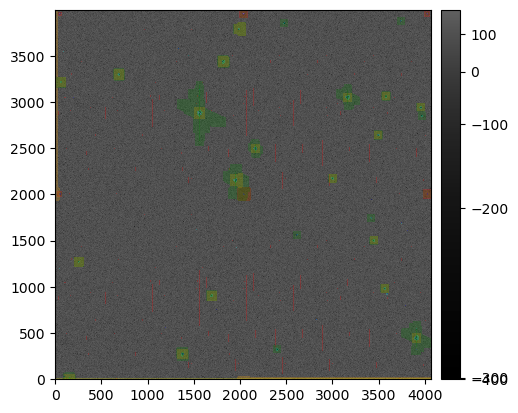

In [62]:
cdia.display_exposure(detection.subtractedMeasuredExposure)

# subtraction works on cropped images

11
(1042, 1024)
12
(1042, 2974)
21
(3028, 1024)
22
(3028, 2974)


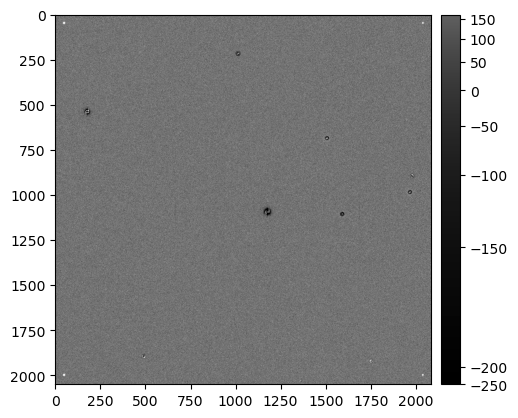

In [68]:

# cropping_paras = cdia.CROPPING_PARAS
# cparas = cropping_paras[cropping_dim]

bbox = science.getBBox()
cropping_dim = 2
width = 50
xshape = bbox.endX - bbox.beginX
yshape = bbox.endY - bbox.beginY
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2
offset = 50
cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)

cropped_exposures = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

diff_dict = {}
for x in range(1, cropping_dim+1):
    for y in range(1, cropping_dim+1):
        print(f'{x}{y}')
        center = cropping_center[f'{x}{y}']
        span = cropping_span[f'{x}{y}']
        print(center)
        science_cutout = cropped_exposures[f'{x}{y}']
        bbox = science_cutout.getBBox()
        source_catalog_selected = cdia.select_source(source_catalog, bbox, offset)
        subtraction = subtract(new_template, science_cutout, source_catalog_selected)
        diff_dict[f'{x}{y}']=subtraction
        
cdia.display_exposure(diff_dict['22'].difference)
from astropy.visualization import ZScaleInterval
interval =  ZScaleInterval()
plt.imshow(interval(diff_dict['22'].difference.getImage().array), cmap='gray')


# injected images

> synthetic source injection

if edge_type == 'left':
     injected_x, injected_y =  span['x_span'][0], center[1]
elif edge_type == 'right':
    injected_x, injected_y =  span['x_span'][1], center[1]
elif edge_type == 'top':
    injected_x, injected_y = center[0], span['y_span'][1]
elif edge_type == 'bottom':
    injected_x, injected_y = center[0], span['y_span'][0]
elif edge_type == 'top_left':
    injected_x, injected_y = span['x_span'][0], span['y_span'][1]
elif edge_type == 'top_right':
    injected_x, injected_y = span['x_span'][1], span['y_span'][1]
elif edge_type == 'bottom_left':
    injected_x, injected_y = span['x_span'][0], span['y_span'][0]
elif edge_type == 'bottom_right':
    injected_x, injected_y = span['x_span'][1], span['y_span'][0]
else:
    print('key word of edge_type is not valid')
return injected_x, injected_y


In [19]:
from lsst.daf.butler import Butler, DimensionUniverse, DatasetType, CollectionType
from lsst.daf.butler.registry import MissingCollectionError
from lsst.source.injection import (ExposureInjectConfig, ExposureInjectTask)
from astropy.table import Table
import lsst.geom as geom

def xy2radec(x, y, wcs):
    radec = geom.SpherePoint(wcs.pixelToSky(x, y))
    ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
    return ra, dec

In [22]:
injection_mag = 20
injection_input_collection = f"u/shl159/injection_demo_{injection_mag:02.0f}p{injection_mag % 1:1d}"
OVERWRITE = True
if OVERWRITE:
    try:
        butler.removeRuns([injection_input_collection])
    except MissingCollectionError:
        print("Writing into a new RUN collection")
        pass
    else:
        print("Prior RUN collection located and successfully removed")

# Register the collection
_ = butler.registry.registerCollection(injection_input_collection, type=CollectionType.RUN)
print(f"Registered collection: {injection_input_collection}")

Prior RUN collection located and successfully removed
Registered collection: u/shl159/injection_demo_20p0


In [80]:
# cropping_paras = cdia.CROPPING_PARAS
# cparas = cropping_paras[cropping_dim]

bbox = science.getBBox()
cropping_dim = 3
width = 50
xshape = bbox.endX - bbox.beginX
yshape = bbox.endY - bbox.beginY
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2
offset = 130
cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)


In [81]:
injection_coords = []
for x in range(1, cropping_dim+1):
    for y in range(1, cropping_dim+1):
        center = cropping_center[f'{x}{y}']
        span = cropping_span[f'{x}{y}']
        # top left: injected_x, injected_y = span['x_span'][0], span['y_span'][1]
        # top right: injected_x, injected_y = span['x_span'][1], span['y_span'][1]
        # injected_x, injected_y = span['x_span'][0], span['y_span'][0] # bottom left
        # injected_x, injected_y = span['x_span'][1], span['y_span'][0] # bottom right
        injection_coords.append([injected_x, injected_y])
wcs = science.getWcs()      
injection_cat = pd.DataFrame(injection_coords, columns=['x', 'y'])
ra, dec = zip(*injection_cat.apply(lambda row: xy2radec(row['x'], row['y'], wcs), axis=1))
injection_cat['ra'] = ra
injection_cat['dec'] = dec
injection_cat['mag'] = injection_mag
injection_cat['source_type'] = 'DeltaFunction'
injection_cat = Table.from_pandas(injection_cat)

inject_config = ExposureInjectConfig()
inject_task = ExposureInjectTask(config=inject_config)

inject_output = inject_task.run(
    injection_catalogs=injection_cat,
    input_exposure=science,
    psf=science.getPsf(),
    wcs=science.getWcs(),
    photo_calib=science.getPhotoCalib(),
)

injected_exposure = inject_output.output_exposure
injected_catalog = inject_output.output_catalog

In [82]:

cropped_exposures_with_ss = cdia.crop_exposure(injected_exposure, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
diff_dict = {}
for x in range(1, cropping_dim+1):
    for y in range(1, cropping_dim+1):
        print(f'{x}{y}')
        center = cropping_center[f'{x}{y}']
        span = cropping_span[f'{x}{y}']
        print(center)
        science_cutout = cropped_exposures_with_ss[f'{x}{y}']
        bbox = science_cutout.getBBox()
        source_catalog_selected = cdia.select_source(source_catalog, bbox, offset)
        subtraction = subtract(template, science_cutout, source_catalog_selected)
        diff_dict[f'{x}{y}']=subtraction

11
(711, 699)
12
(711, 1999)
13
(711, 3299)
21
(2035, 699)
22
(2035, 1999)
23
(2035, 3299)
31
(3359, 699)
32
(3359, 1999)
33
(3359, 3299)


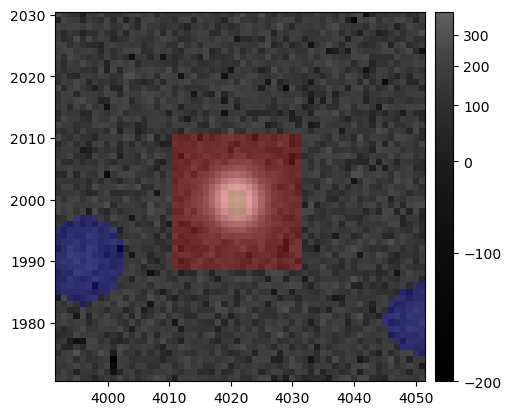

In [83]:
idx = 3
cdia.display_exposure(injected_exposure, crop_exposure=True, cutout_x=injection_cat[idx]['x'], cutout_y=injection_cat[idx]['y'])

- mag 20, host 20

- mag 23, host 20

- mag 20, host 23

- mag 23, host 23

In [59]:
detection = detect(science=injected_exposure, subtraction=subtraction)


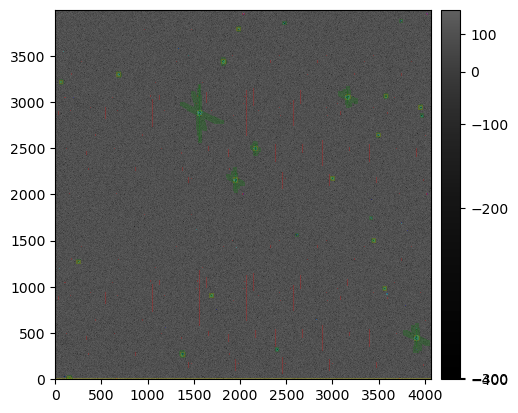

In [60]:
cdia.display_exposure(detection.subtractedMeasuredExposure)

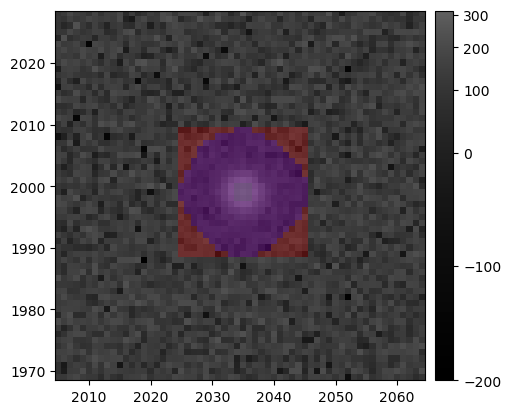

In [61]:
idx = 0
cdia.display_exposure(detection.subtractedMeasuredExposure, crop_exposure=True, cutout_x=injection_cat[idx]['x'], cutout_y=injection_cat[idx]['y'])

In [63]:
cropped_exposures_with_ss = cdia.crop_exposure(injected_exposure, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
diff_dict = {}
for x in range(1, cropping_dim+1):
    for y in range(1, cropping_dim+1):
        print(f'{x}{y}')
        center = cropping_center[f'{x}{y}']
        span = cropping_span[f'{x}{y}']
        print(center)
        science_cutout = cropped_exposures_with_ss[f'{x}{y}']
        bbox = science_cutout.getBBox()
        source_catalog_selected = cdia.select_source(source_catalog, bbox, offset)
        subtraction = subtract(template, science_cutout, source_catalog_selected)
        diff_dict[f'{x}{y}']=subtraction

11
(1042, 1024)
12
(1042, 2974)
21
(3028, 1024)
22
(3028, 2974)


In [ ]:
in imag

In [73]:
def injection_on_bottom_right(exposure, injected_mag, cropping_dim, cropping_center, cropping_span):
    exposure_clone = exposure.clone()
    photo_calib = exposure_clone.getPhotoCalib()
    for x in range(1, cropping_dim+1):
        for y in range(1, cropping_dim+1):
            center = cropping_center[f'{x}{y}']
            span = cropping_span[f'{x}{y}']
            injected_x, injected_y = span['x_span'][1], span['y_span'][1]
            cdia.inject_star(exposure_clone, photo_calib, injected_x, injected_y, mag=injected_mag)
    return exposure_clone

In [74]:
injected_mag = 20
cropping_dim = 2
science_ss = injection_on_bottom_right(science, injected_mag, cropping_dim, cropping_center, cropping_span)

In [75]:
cropped_exposures_with_ss = cdia.crop_exposure(science_ss, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

In [76]:
diff_dict = {}
for x in range(1, cropping_dim+1):
    for y in range(1, cropping_dim+1):
        print(f'{x}{y}')
        center = cropping_center[f'{x}{y}']
        span = cropping_span[f'{x}{y}']
        print(center)
        science_cutout = cropped_exposures_with_ss[f'{x}{y}']
        bbox = science_cutout.getBBox()
        source_catalog_selected = cdia.select_source(source_catalog, bbox, offset)
        subtraction = subtract(template, science_cutout, source_catalog_selected)
        diff_dict[f'{x}{y}']=subtraction

11
(1167, 1149)
12
(1167, 2849)
21
(2903, 1149)
22
(2903, 2849)


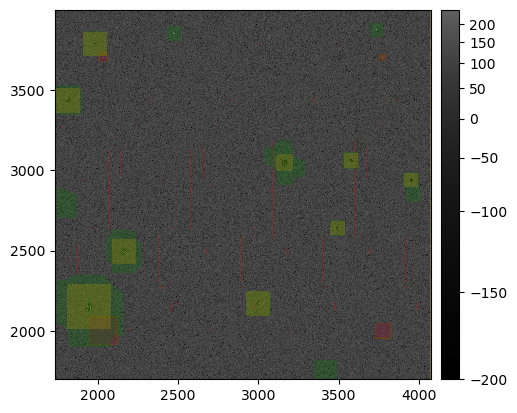

In [78]:
cdia.display_exposure(diff_dict['22'].difference)

In [ ]:
cdia.display_exposure(diff_dict['22'].difference)

# Algorithm

In [10]:
def min_of_src(cropping_dim, science_cutout_dict, source_catalog):
    src_count = []
    for x in range(1, cropping_dim+1):
        for y in range(1, cropping_dim+1):
            science_cutout = science_cutout_dict[f'{x}{y}']
            bbox = science_cutout.getBBox()
            source_catalog_selected = cdia.select_source(source_catalog, bbox, offset=10)
            src_count.append(len(source_catalog_selected))
    print('mininum number of selected src in a cropped exposure: ', np.min(src_count))

    
def get_injected_coord(center, span, edge_type):
    if edge_type == 'left':
         injected_x, injected_y =  span['x_span'][0], center[1]
    elif edge_type == 'right':
        injected_x, injected_y =  span['x_span'][1], center[1]
    elif edge_type == 'top':
        injected_x, injected_y = center[0], span['y_span'][1]
    elif edge_type == 'bottom':
        injected_x, injected_y = center[0], span['y_span'][0]
    elif edge_type == 'top_left':
        injected_x, injected_y = span['x_span'][0], span['y_span'][1]
    elif edge_type == 'top_right':
        injected_x, injected_y = span['x_span'][1], span['y_span'][1]
    elif edge_type == 'bottom_left':
        injected_x, injected_y = span['x_span'][0], span['y_span'][0]
    elif edge_type == 'bottom_right':
        injected_x, injected_y = span['x_span'][1], span['y_span'][0]
    else:
        print('key word of edge_type is not valid')
    return injected_x, injected_y


def test_injection_on_edge(exposure, injected_mag, cropping_dim, cropping_center, cropping_span, edge_type):
    exposure_clone = exposure.clone()
    photo_calib = exposure_clone.getPhotoCalib()
    for x in range(1, cropping_dim+1):
        for y in range(1, cropping_dim+1):
            center = cropping_center[f'{x}{y}']
            span = cropping_span[f'{x}{y}']
            injected_x, injected_y = get_injected_coord(center, span, edge_type)
            cdia.inject_star(exposure_clone, photo_calib, injected_x, injected_y, mag=injected_mag)
    return exposure_clone

def show_injected_stamps(exposure, cropping_dim, cropping_center, cropping_span, edge_type):
    fig, axes = plt.subplots(cropping_dim, cropping_dim, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.6)
    for x in range(1, cropping_dim+1):
        for y in range(1, cropping_dim+1):
            print(f'{x}{y}')
            center = cropping_center[f'{x}{y}']
            span = cropping_span[f'{x}{y}']
            injected_x, injected_y = get_injected_coord(center, span, edge_type)
            print(injected_x, injected_y)
            cdia.display_exposure_on_axis(fig, axes[cropping_dim-1-(y-1)][x-1], exposure, crop_exposure=True, cutout_x=injected_x, cutout_y=injected_y, cutout_size=500)



def test_subtraction(template, science, source_catalog, cropping_dim, cropping_center, cropping_span, cropped_exposures, data_dir, offset = 10):
    
    concat_sources = pd.DataFrame()
    for x in range(1, cropping_dim+1):
        for y in range(1, cropping_dim+1):
            print(f'{x}{y}')

            center = cropping_center[f'{x}{y}']
            span = cropping_span[f'{x}{y}']
            # cx, cy = center[0], center[1]
            print(center)

            science_cutout = cropped_exposures[f'{x}{y}']
            bbox = science_cutout.getBBox()
            source_catalog_selected = cdia.select_source(source_catalog, bbox, offset)
            subtraction, detection = cdia.run_subtraction(science_cutout, template, source_catalog_selected, spatialKernelOrder=1, get_detection=True, verbose=True)

            diaSources = detection.diaSources.asAstropy().to_pandas()
            in_span_result = cdia.in_span(diaSources, span)
            diaSources['in_span'] = in_span_result
            diaSources['cutout_id'] = np.repeat(f'{x}{y}', len(diaSources))
            concat_sources = pd.concat([concat_sources, diaSources])
            detection.subtractedMeasuredExposure.writeFits(os.path.join(data_dir, f'diff_{x}{y}.fits'))
    concat_sources = concat_sources.reset_index(drop=True)
    concat_sources.to_csv(os.path.join(data_dir, 'concat_diaSources.csv'), index=False)
    print(f'{concat_sources.in_span.sum()} detected sources')

In [11]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 2
cparas = cropping_paras[cropping_dim]
width = 300
xshape = bbox.endX - bbox.beginX
yshape = bbox.endY - bbox.beginY
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)

injected_mag = 20
edge_type = 'bottom_right'

In [32]:
# science_injection = test_injection_on_edge(science, injected_mag, cropping_dim, cropping_center, cropping_span, edge_type)
# cropped_exposures = cdia.crop_exposure(science_injection, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

cropped_exposures = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

In [33]:
cropped_exposures

{'11': <lsst.afw.image._exposure.ExposureF at 0x7f90cd6affb0>,
 '12': <lsst.afw.image._exposure.ExposureF at 0x7f90cd4f6870>,
 '21': <lsst.afw.image._exposure.ExposureF at 0x7f90cd7bbd70>,
 '22': <lsst.afw.image._exposure.ExposureF at 0x7f90cd6fd2b0>}

data_dir = './test_cdia/cropping_size'
test_subtraction(template, science, source_catalog, cropping_dim, cropping_center, cropping_span, cropped_exposures, data_dir, offset=50)


In [11]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 2
cparas = cropping_paras[cropping_dim]
width = 100
xshape = bbox.endX - bbox.beginX
yshape = bbox.endY - bbox.beginY
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)

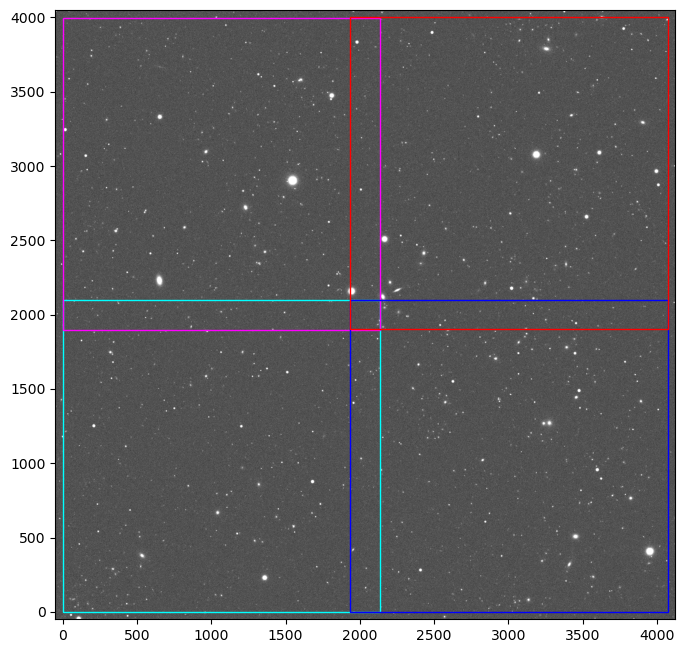

In [12]:
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span, show_detection_grid=False)

mininum number of selected src in a cropped exposure:  692


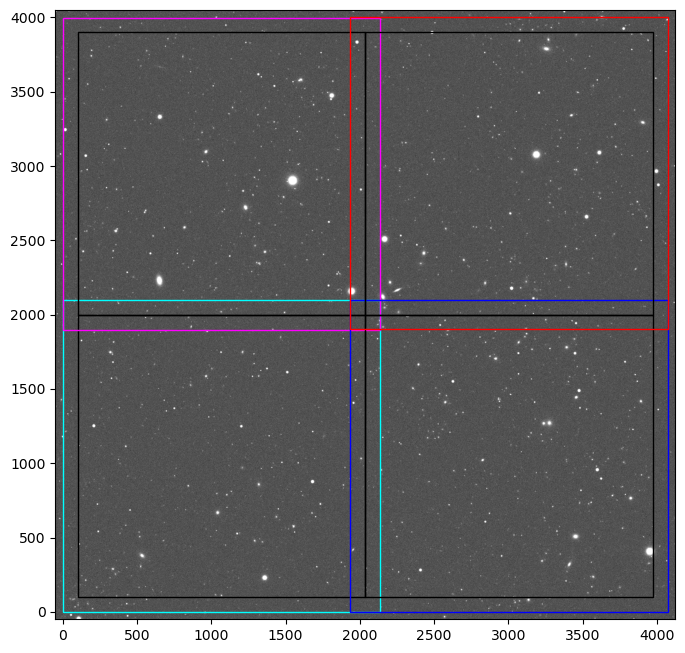

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)
plt.savefig('cdia.png', dpi=100)

mininum number of selected src in a cropped exposure:  306


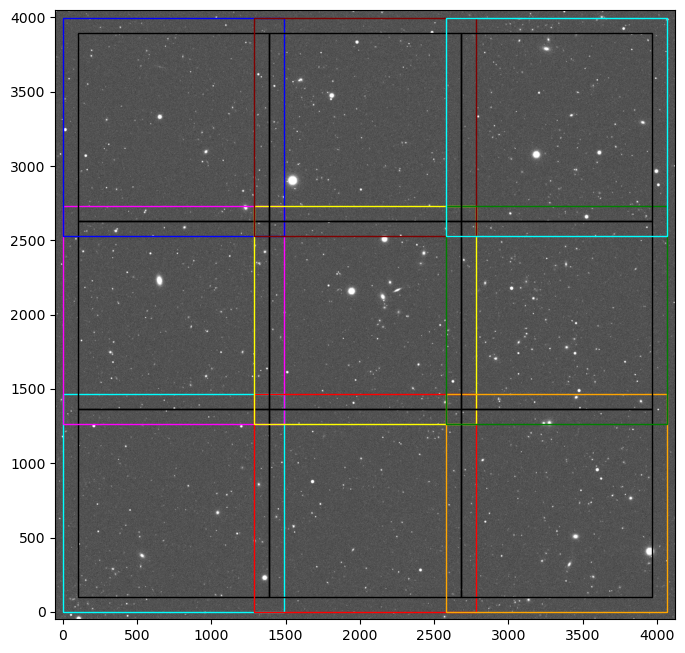

In [13]:
cropping_dim = 3
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

mininum number of selected src in a cropped exposure:  168


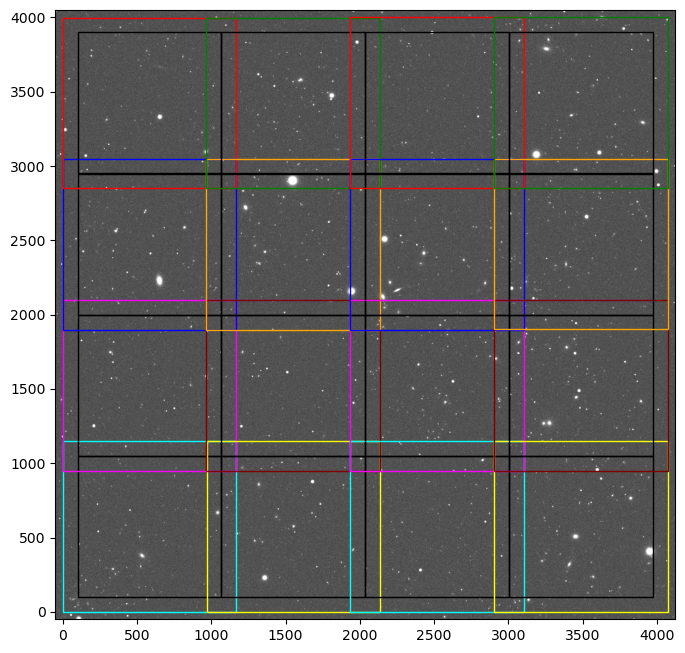

In [14]:
cropping_dim = 4
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

mininum number of selected src in a cropped exposure:  112


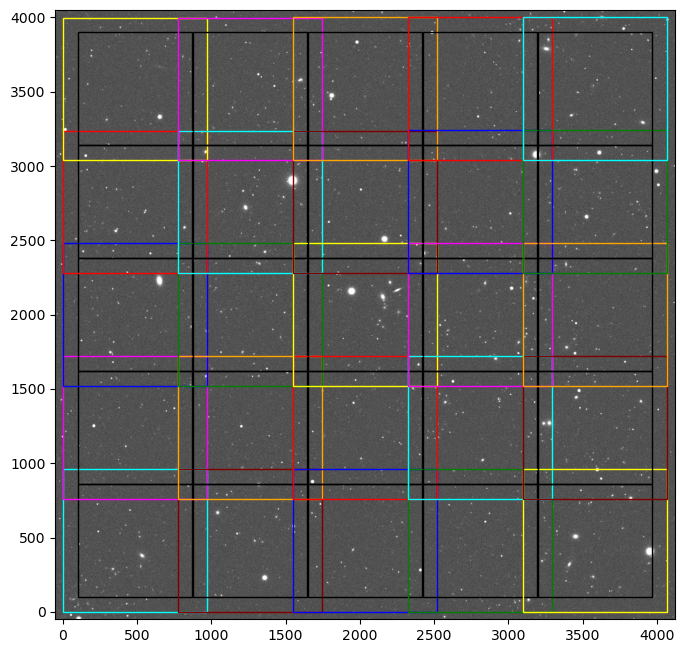

In [15]:
cropping_dim = 5
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

mininum number of selected src in a cropped exposure:  72


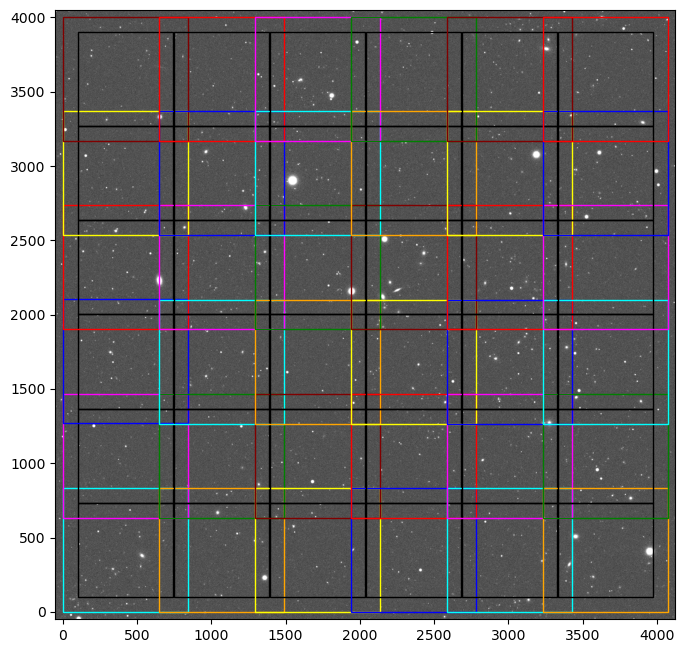

In [16]:
cropping_dim = 6
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

mininum number of selected src in a cropped exposure:  61


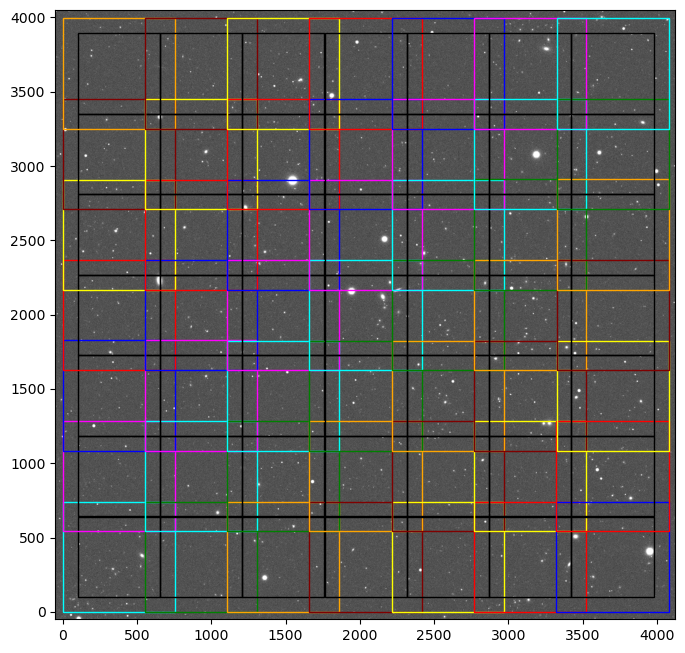

In [17]:
cropping_dim = 7
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

mininum number of selected src in a cropped exposure:  43


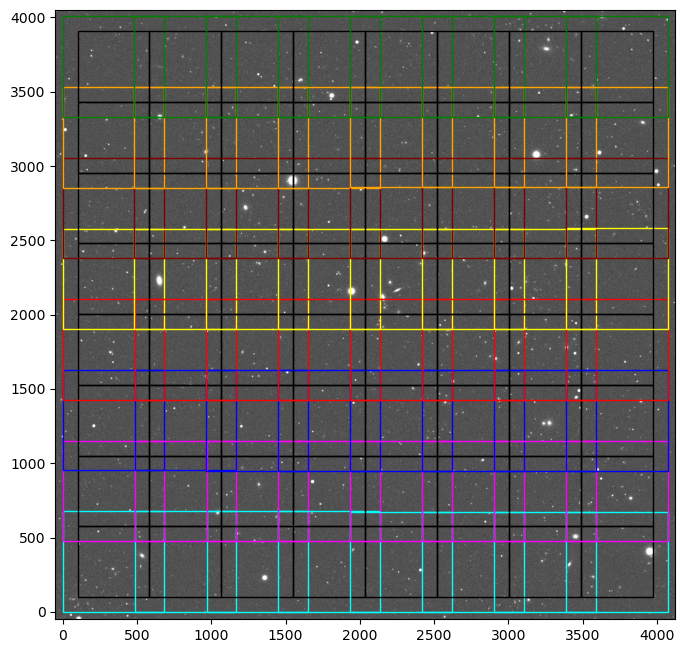

In [18]:
cropping_dim = 8
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

mininum number of selected src in a cropped exposure:  33


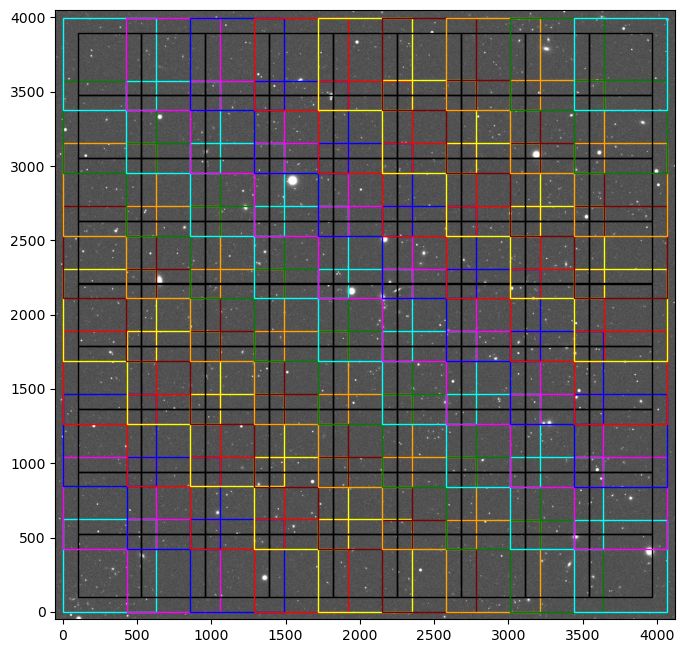

In [19]:
cropping_dim = 9
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

mininum number of selected src in a cropped exposure:  23


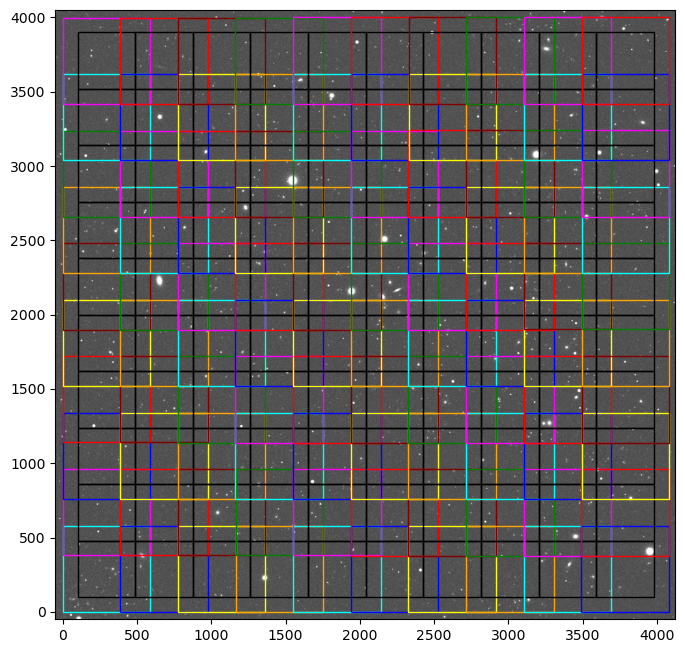

In [20]:
cropping_dim = 10
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)
min_of_src(cropping_dim, science_cutout_dict, source_catalog)

# Synthetic Source Injection

In [11]:
def get_injected_coord(center, span, edge_type):
    if edge_type == 'left':
         injected_x, injected_y =  span['x_span'][0], center[1]
    elif edge_type == 'right':
        injected_x, injected_y =  span['x_span'][1], center[1]
    elif edge_type == 'top':
        injected_x, injected_y = center[0], span['y_span'][1]
    elif edge_type == 'bottom':
        injected_x, injected_y = center[0], span['y_span'][0]
    elif edge_type == 'top_left':
        injected_x, injected_y = span['x_span'][0], span['y_span'][1]
    elif edge_type == 'top_right':
        injected_x, injected_y = span['x_span'][1], span['y_span'][1]
    elif edge_type == 'bottom_left':
        injected_x, injected_y = span['x_span'][0], span['y_span'][0]
    elif edge_type == 'bottom_right':
        injected_x, injected_y = span['x_span'][1] - 100, span['y_span'][0] + 100
    else:
        print('key word of edge_type is not valid')
    return injected_x, injected_y

### 2 * 2

In [11]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 2
cparas = cropping_paras[cropping_dim]
width = 300
xshape = bbox.endX - bbox.beginX
yshape = bbox.endY - bbox.beginY
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)

injected_mag = 20
edge_type = 'bottom_right'

In [12]:
# science_injection = test_injection_on_edge(science, injected_mag, cropping_dim, cropping_center, cropping_span, edge_type)
# cropped_exposures = cdia.crop_exposure(science_injection, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

cropped_exposures = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

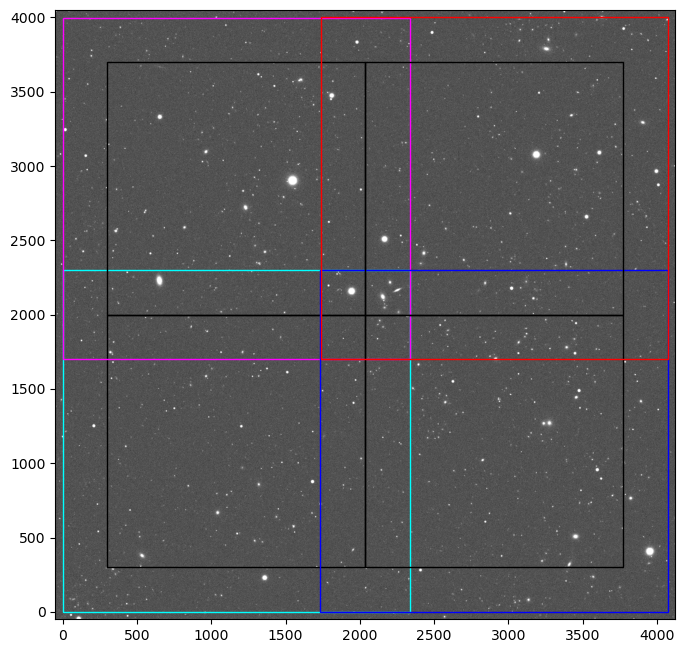

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, cropped_exposures, cropping_dim, cropping_span)

11
2035 300
12
2035 2000
21
3771 300
22
3771 2000


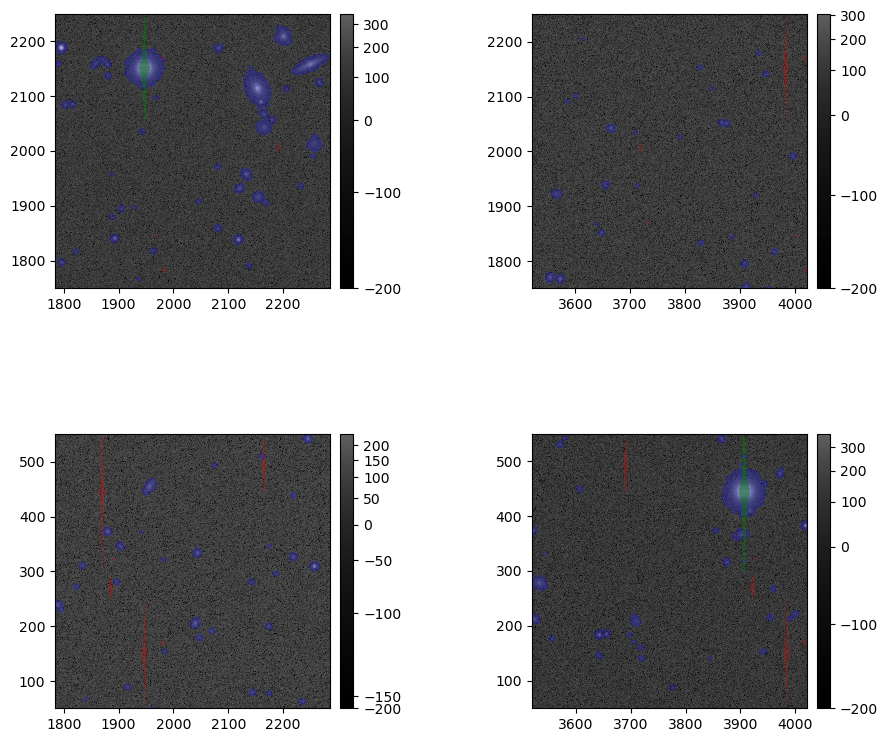

In [14]:
show_injected_stamps(science, cropping_dim, cropping_center, cropping_span, edge_type)

if we do not crop the science image

In [17]:
subtraction, detection = cdia.run_subtraction(science_injection, template, source_catalog, spatialKernelOrder=1, get_detection=True, verbose=True)

-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
2710 stars are used for fitting: 
-------------------------------------------------------------------------------------------------


In [31]:
subtraction, detection = cdia.run_subtraction(science, template, source_catalog, spatialKernelOrder=1, get_detection=True, verbose=True)

-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
2710 stars are used for fitting: 
-------------------------------------------------------------------------------------------------


In [32]:
print('done')

done


the second exposure failed

In [ ]:
data_dir = './test_cdia/cropping_size'
test_subtraction(template, science, source_catalog, cropping_dim, cropping_center, cropping_span, cropped_exposures, data_dir, offset=50)

11
(1167, 1149)
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
778 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
12
(1167, 2849)
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
804 stars are used for fitting: 
-------------------------------------------------------------------------------------------------


In [20]:
key = '12'
science_cutout = cropped_exposures[key]

In [21]:
offset = 10
bbox = science_cutout.getBBox()
source_catalog_selected = cdia.select_source(source_catalog, bbox, offset)

In [ ]:
subtraction, detection = cdia.run_subtraction(science_cutout, template, source_catalog_selected, spatialKernelOrder=1, get_detection=True, verbose=True)

-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
761 stars are used for fitting: 
-------------------------------------------------------------------------------------------------


conclution

1. subtract cropped exposures without injection, fail
3. subtract cropped exposures with injection, fail
4. subtract uncropped exposure with injection, succeed


cropping is the issue







error in terminal:

python: /build/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/include/boost/gil/image_view.hpp:298: boost::gil::image_view<L>::xy_locator boost::gil::image_view<L>::xy_at(boost::gil::image_view<L>::x_coord_t, boost::gil::image_view<L>::y_coord_t) const [with Loc = boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mp11::mp_list<boost::gil::gray_color_t> > >*> >; boost::gil::image_view<L>::xy_locator = boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mp11::mp_list<boost::gil::gray_color_t> > >*> >; boost::gil::image_view<L>::x_coord_t = long int; boost::gil::image_view<L>::y_coord_t = long int]: Assertion `y <= height()' failed.
Aborted
            


### 3 * 3

In [17]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 3
cparas = cropping_paras[cropping_dim]
width = 100
xshape = bbox.endX - bbox.beginX
yshape = bbox.endY - bbox.beginY
Lx = cdia.cal_L(cropping_dim, width, shape=xshape)
Ly = cdia.cal_L(cropping_dim, width, shape=yshape)
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)

injected_mag = 20
edge_type = 'bottom_right'

science_injection = test_injection_on_edge(science, injected_mag, cropping_dim, cropping_center, cropping_span, edge_type)
cropped_exposures = cdia.crop_exposure(science_injection, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

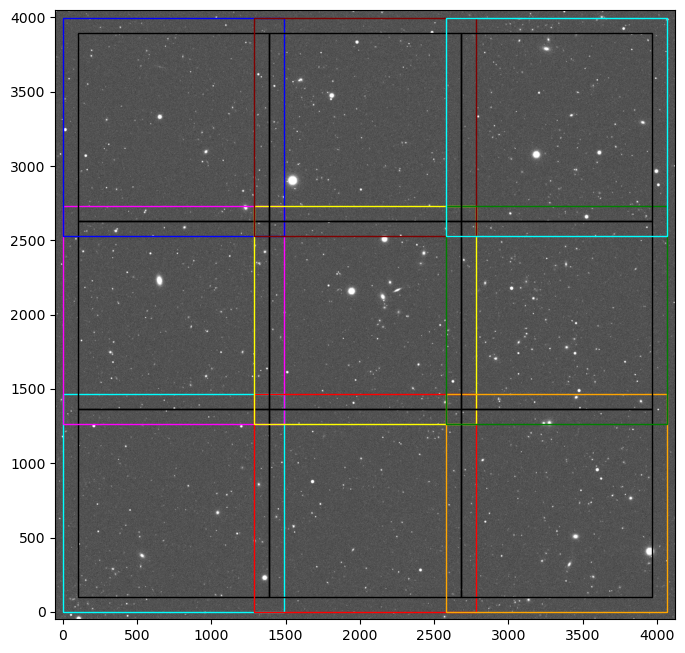

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, cropped_exposures, cropping_dim, cropping_span)

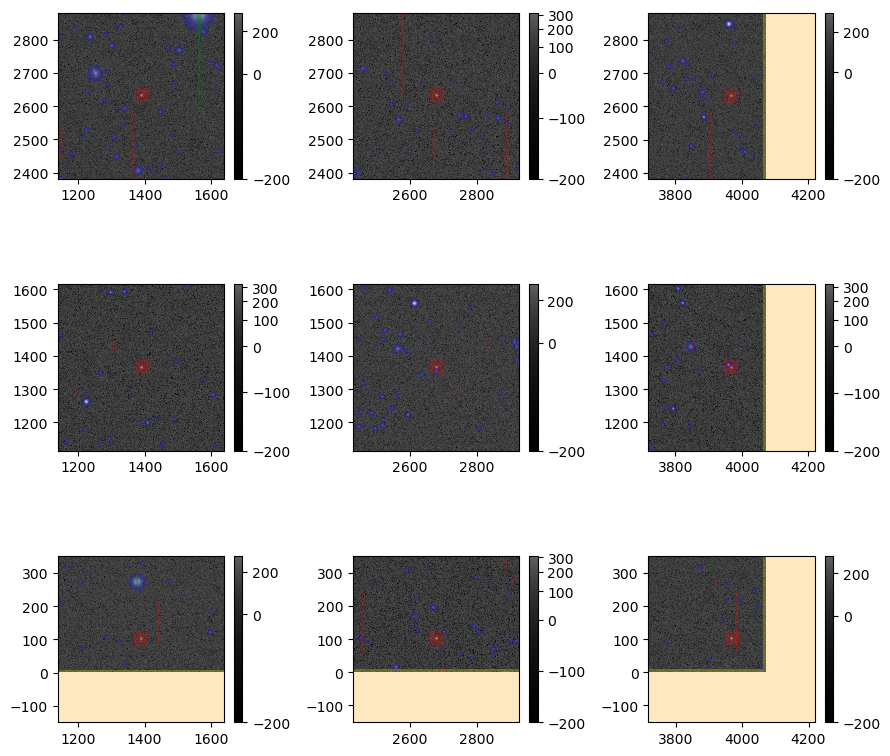

In [19]:
show_injected_stamps(science_injection, cropping_dim, cropping_center, cropping_span, edge_type)

In [ ]:
data_dir = './test_cdia/cropping_size'
test_subtraction(template, science, source_catalog, cropping_dim, cropping_center, cropping_span, cropped_exposures, data_dir)

-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
371 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
372 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
